## Feature Examination CVD dataset

In [172]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Build the CVD training dataset
I need to load the core spreadsheet, and load the extra spreadsheet where required
Then I need to match the IDs. THen we have a spreadsheet that we can fit a logistic regression model with

In [59]:
CVD_core_df = pd.read_csv("../umap_data_spreadsheets/CVD/clinscore_data.csv")

In [60]:
CVD_core_df

,Unnamed: 0.1,Unnamed: 0,ID,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,...,micrBld,smoking_0,smoking_1,smoking_2,total_fazekas,scale_fazekas,scale_pvs,scale_micrbld,stroke_les,scale_stroke
0,146,146,CVD247,1,68.0,2,0,1,1.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,1.0,NaN,1.0,1.0
1,134,134,CVD219,1,81.0,1,0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,0.0,1.0,NaN,1.0,0.0
2,131,131,CVD195,1,71.0,1,0,1,0.0,2.0,...,1.0,0.0,0.0,1.0,6.0,1.0,1.0,NaN,1.0,1.0
3,121,121,CVD173,1,68.0,1,0,1,0.0,2.0,...,0.0,0.0,0.0,1.0,4.0,1.0,0.0,NaN,1.0,0.0
4,104,104,CVD128,1,83.0,1,0,0,0.0,1.0,...,0.0,0.0,1.0,0.0,3.0,0.0,0.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,201,201,CVD302,1,55.0,1,0,1,0.0,2.0,...,0.0,0.0,0.0,1.0,2.0,0.0,1.0,NaN,1.0,1.0
246,138,138,CVD230,1,50.0,1,0,0,1.0,2.0,...,0.0,0.0,0.0,1.0,3.0,0.0,1.0,NaN,1.0,1.0
247,107,107,CVD132,1,56.0,1,0,0,0.0,2.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,NaN,1.0,0.0
248,215,215,CVD316,1,78.0,1,0,1,1.0,2.0,...,1.0,0.0,0.0,1.0,2.0,0.0,0.0,NaN,1.0,0.0


In [61]:
CVD_core_df.loc[CVD_core_df['ID'] == "CVD152"]

,Unnamed: 0.1,Unnamed: 0,ID,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,...,micrBld,smoking_0,smoking_1,smoking_2,total_fazekas,scale_fazekas,scale_pvs,scale_micrbld,stroke_les,scale_stroke
214,112,112,CVD152,1,81.0,1,0,1,1.0,1.0,...,1.0,0.0,1.0,0.0,3.0,0.0,1.0,NaN,1.0,0.0


### Add the sample diversity data

In [62]:
sample_div_df = pd.read_csv("../umap_data_spreadsheets/CVD/sample_div_data_SSN_Ens.csv")

In [63]:
sample_div_df = sample_div_df.drop(columns="Unnamed: 0")

In [64]:
CVD_core_df = CVD_core_df.merge(sample_div_df, on="ID")
CVD_core_df = CVD_core_df.drop(columns="Unnamed: 0.1")
CVD_core_df = CVD_core_df.loc[CVD_core_df['dice'] > 0.005 ] # get rid of the examples where the image was broken when presented to the dataloader and resulted in dice of 0.

In [65]:
CVD_core_df.loc[CVD_core_df['ID'] == "CVD152"]

,Unnamed: 0,ID,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,SBP,...,dice,f1,avd,recall,sample_div_std,sample_div_IQR,sample_div_skew,sample_div_vd_std,sample_div_vd_IQR,sample_div_vd_skew
214,112,CVD152,1,81.0,1,0,1,1.0,1.0,170.0,...,0.811133,0.594828,13.568752,0.555556,3069.769531,2830.75,1.117674,29.423723,25.118235,1.717294


CVD_core_df### Explore how base features vary with Fazekas (and what the class balance is)

In [233]:
sns.set_style("whitegrid")

In [114]:
def get_uniques(df, key):
    values = df[key].values
    uniques = np.unique(values)
    uniques = uniques[np.logical_not(np.isnan(uniques))] # remove nan, if it is there
    return uniques

In [183]:
def simple_hist_bar_plot(ax, df, key, xlabel, color='#1cdaeb'):
    ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=0)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=0)
    classes = get_uniques(df, key)
    values = df[key].values
    counts = [0 for _ in range(len(classes))]
    for i, c in enumerate(classes):
        counts[i] = np.sum(values == c)
    ax.bar(classes, counts, zorder=2, color=color); # zorder 2 is above grid but below axis (3 puts it above the axis
    if xlabel == None:
        xlabel = key
    ax.set_xlabel(xlabel)
    ax.set_ylabel("count")
    ax.set_xticks(classes)
    ax.spines[['top','right']].set_visible(False) # Remove the top and right spines
    ax.spines[['left', 'bottom']].set_linewidth(1.1) # make the left and bottom spines thicker#
    ax.spines[['left', 'bottom']].set_color('#585858')

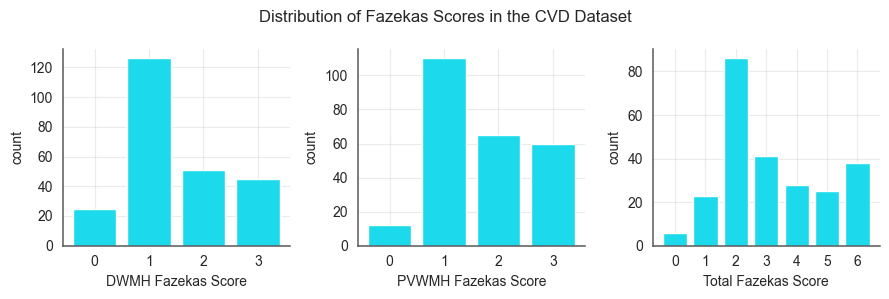

In [232]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
simple_hist_bar_plot(axs[0], CVD_core_df, 'DWMH', 'DWMH Fazekas Score')
simple_hist_bar_plot(axs[1], CVD_core_df, 'PVWMH', 'PVWMH Fazekas Score')
simple_hist_bar_plot(axs[2], CVD_core_df, 'total_fazekas', 'Total Fazekas Score')
plt.suptitle("Distribution of Fazekas Scores in the CVD Dataset")
fig.tight_layout()

### How does WMH volume predict fazekas score?

In [404]:
def simple_box_plot(ax, df, x, y, xlabel=None, ylabel=None, logy=False, logx=False, kind='box'):
    if kind == 'box':
        ax = sns.boxplot(data=df, x=x, y=y, ax=ax)
    elif kind == 'violin':
        ax = sns.violinplot(data=df, x=x, y=y, ax=ax, cut=0, bw=.15)
    if xlabel == None:
        xlabel = x
    if ylabel == None:
        ylabel = y
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.spines[['top','right']].set_visible(False) # Remove the top and right spines
    ax.spines[['left', 'bottom']].set_linewidth(1.1) # make the left and bottom spines thicker#
    ax.spines[['left', 'bottom']].set_color('#585858')
    if logy:
        ax.set_yscale('log')
    if logx:
        ax.set_xscale('log')

In [373]:
def simple_scatter_plot(ax, df, x, y, hue=None, xlabel=None, ylabel=None, logy=False, logx=False):
    ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())
    if xlabel == None:
        xlabel = x
    if ylabel == None:
        ylabel = y
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.spines[['top','right']].set_visible(False) # Remove the top and right spines
    ax.spines[['left', 'bottom']].set_linewidth(1.1) # make the left and bottom spines thicker#
    ax.spines[['left', 'bottom']].set_color('#585858')
    if logy:
        ax.set_yscale('log')
    if logx:
        ax.set_xscale('log')
    print(get_uniques(df, hue))
    plt.legend(loc='lower right', title=hue)

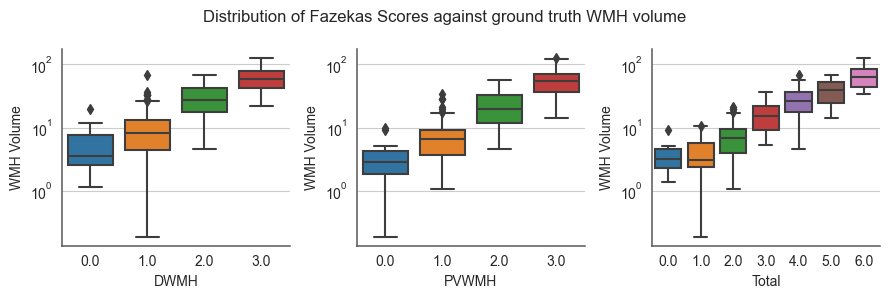

In [339]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
simple_box_plot(axs[0], CVD_core_df, x='DWMH', y='WMH', ylabel="WMH Volume", logy=True)
simple_box_plot(axs[1], CVD_core_df, x='PVWMH', y='WMH', ylabel="WMH Volume", logy=True)
simple_box_plot(axs[2], CVD_core_df, x='total_fazekas', y='WMH', xlabel='Total', ylabel="WMH Volume", logy=True)
plt.suptitle("Distribution of Fazekas Scores against ground truth WMH volume")
fig.tight_layout()

### examine how each feature distributes with volume and fazekas category (PVWMH, DWMH, Total, then GT WMH Volume)
dice, lesion f1, avd, sample_div_std, sample_div_IQR, sample_div_skew, and vd equivalents

In [434]:
def quad_fazekas_comparison_plot_box(df, y, ylabel, kind='box', logy=False):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    simple_box_plot(axs[0], df, x='DWMH', y=y, ylabel=ylabel, kind=kind, logy=logy)
    simple_box_plot(axs[1], df, x='PVWMH', y=y, ylabel=ylabel, kind=kind, logy=logy)
    simple_box_plot(axs[2], df, x='total_fazekas', y=y, xlabel='Total', ylabel=ylabel, kind=kind, logy=logy)
    simple_scatter_plot(axs[3], df, x=y, y='WMH', hue='DWMH', xlabel=ylabel, ylabel="WMH Volume", logy=True, logx=logy)
    if ylabel == None:
        ylabel = y
    plt.suptitle(f"Distribution of {ylabel} across Fazekas Scores")
    fig.tight_layout()

/tmp/ipykernel_735809/79551443.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


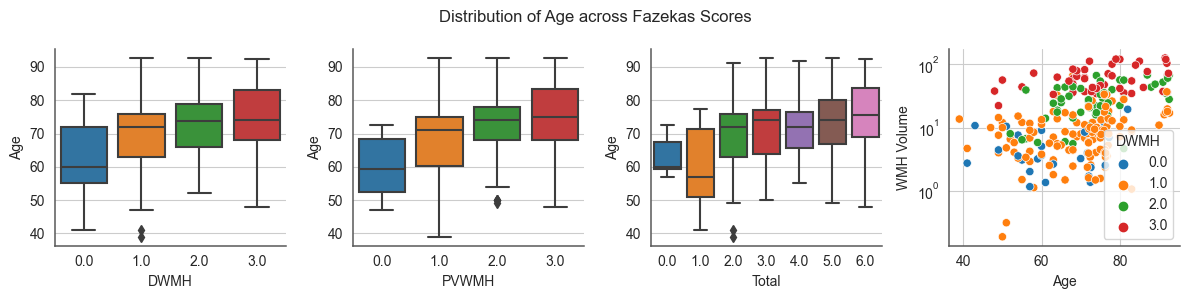

In [356]:
quad_fazekas_comparison_plot_box(CVD_core_df, y='age', ylabel='Age')

/tmp/ipykernel_735809/79551443.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


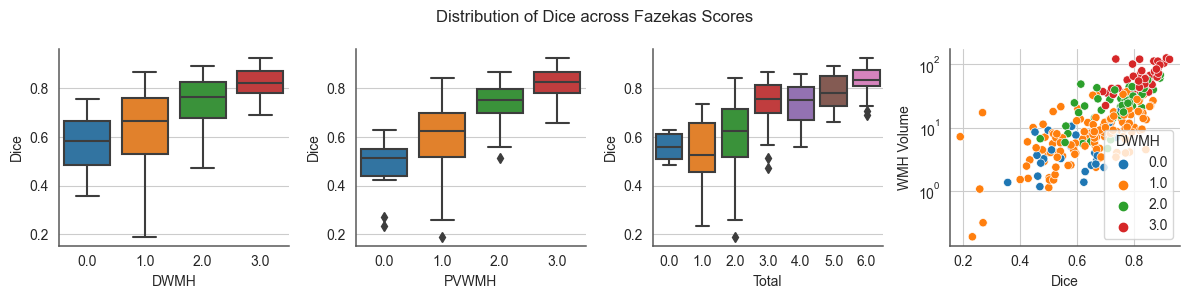

In [357]:
quad_fazekas_comparison_plot_box(CVD_core_df, y='dice', ylabel='Dice', kind='box')

/tmp/ipykernel_735809/79551443.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


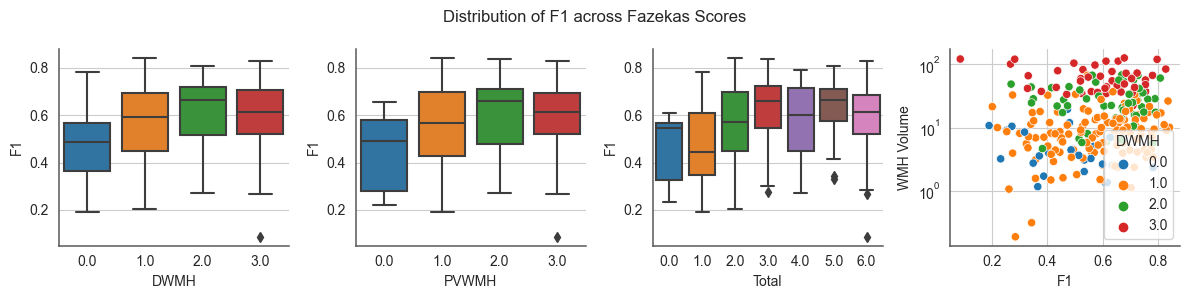

In [358]:
quad_fazekas_comparison_plot_box(CVD_core_df, y='f1', ylabel='F1', kind='box')

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


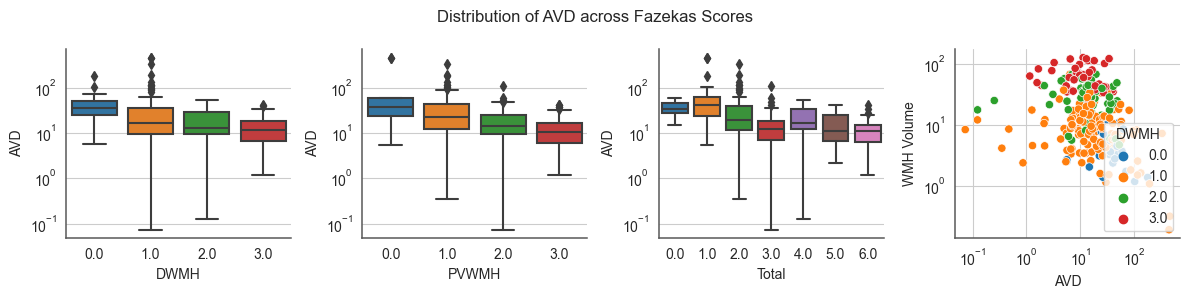

In [377]:
quad_fazekas_comparison_plot_box(CVD_core_df, y='avd', ylabel='AVD', kind='box', logy=True)

/tmp/ipykernel_735809/79551443.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


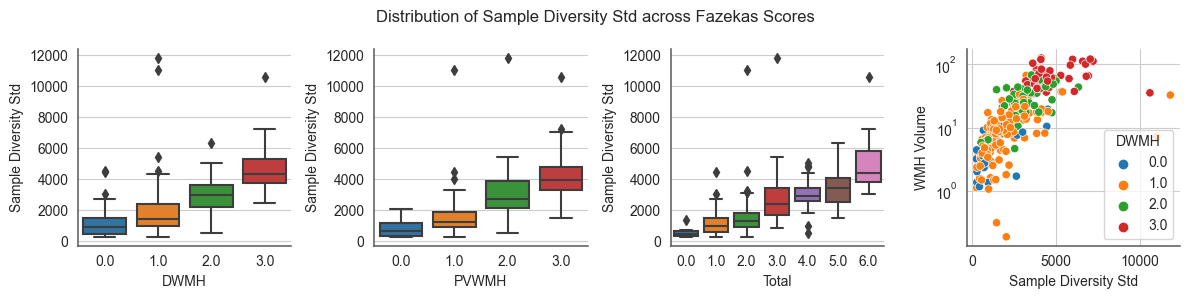

In [359]:
quad_fazekas_comparison_plot_box(CVD_core_df, y='sample_div_std', ylabel='Sample Diversity Std', kind='box')

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


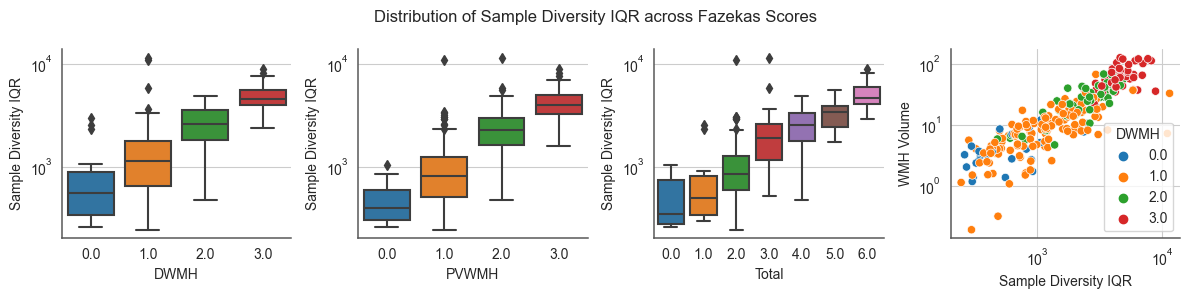

In [378]:
quad_fazekas_comparison_plot_box(CVD_core_df, y='sample_div_IQR', ylabel='Sample Diversity IQR', kind='box', logy=True)

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


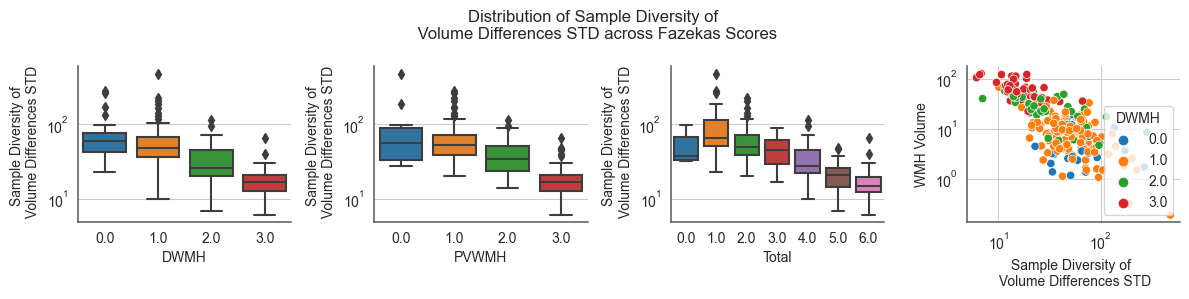

In [379]:
quad_fazekas_comparison_plot_box(CVD_core_df, y='sample_div_vd_std', ylabel='Sample Diversity of \n Volume Differences STD', kind='box', logy=True)

/tmp/ipykernel_735809/79551443.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


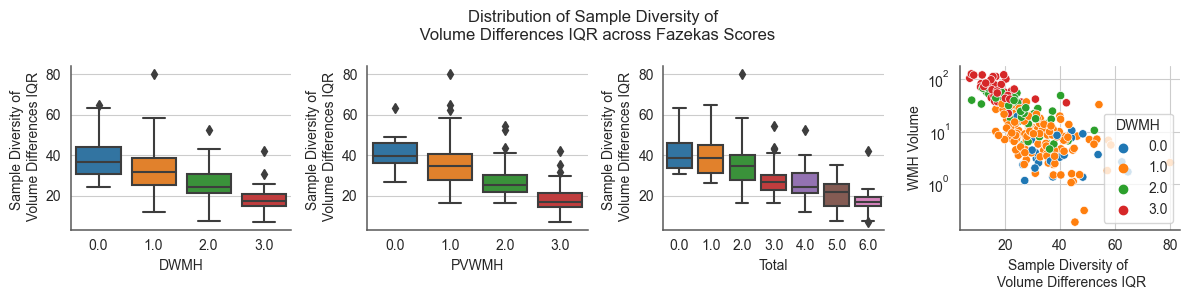

In [367]:
quad_fazekas_comparison_plot_box(CVD_core_df, y='sample_div_vd_IQR', ylabel='Sample Diversity of \n Volume Differences IQR', kind='box')

/tmp/ipykernel_735809/79551443.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


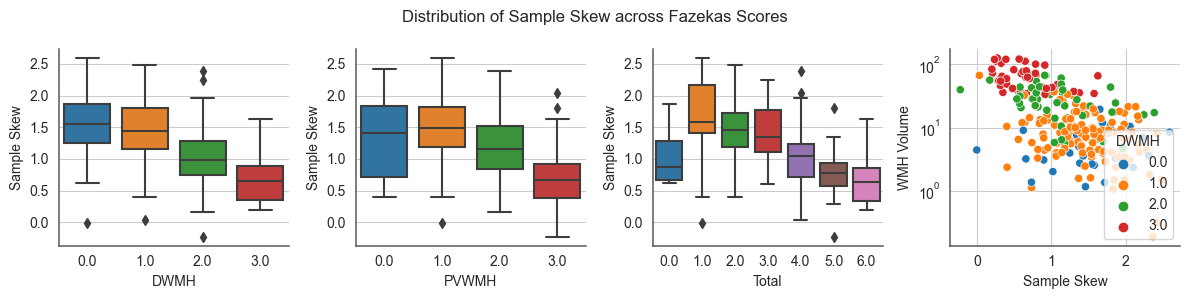

In [368]:
quad_fazekas_comparison_plot_box(CVD_core_df, y='sample_div_skew', ylabel='Sample Skew', kind='box')

/tmp/ipykernel_735809/79551443.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


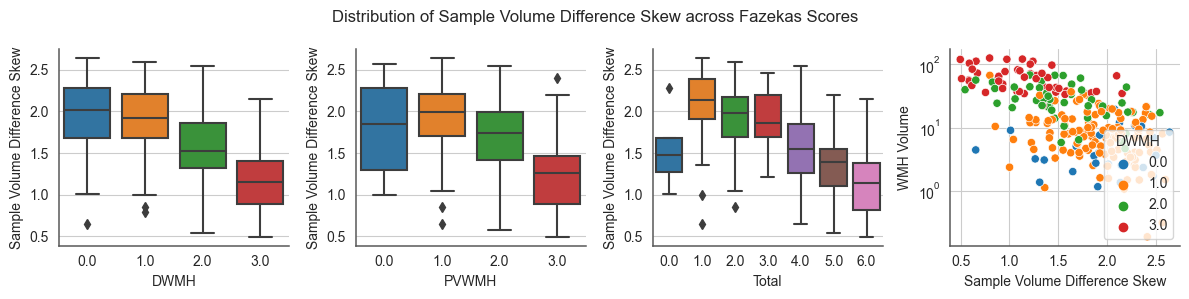

In [369]:
quad_fazekas_comparison_plot_box(CVD_core_df, y='sample_div_vd_skew', ylabel='Sample Volume Difference Skew', kind='box')

### Add Umap feature data

In [383]:
def load_model_output_stats(output_type, threshold, fields=None):
    df = pd.read_csv(f"../umap_data_spreadsheets/CVD/{output_type}_{threshold}.csv")
    if fields != None:
        return df[fields]
    return df

In [384]:
def merge_datasets(core_df, output_types, thresholds, selected_fields):
    for output_type, thresh, fields in zip(output_types, thresholds, selected_fields):
        
        extra_df = load_model_output_stats(output_type, thresh, fields) # load the specific output type at the given threshold, and select the desired fields
        
        extra_df = extra_df.rename(columns={key: f"{output_type}{thresh}_{key}" if key != 'ID' else 'ID' for key in extra_df.keys()}) # modify the column name so that we know which columns belong to which input type
        
        core_df = core_df.merge(extra_df, on="ID")
    
    core_df = core_df.drop(columns='ID')       
    
    return core_df

In [385]:
all_image_extracted_fields = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean',
       'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew',
       'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt',
       'dist_value_joint_0', 'dist_value_joint_1', 'dist_value_joint_2',
       'dist_value_joint_3', 'dist_value_joint_4', 'dist_value_joint_5',
       'dist_value_joint_6', 'dist_value_joint_7', 'dist_value_joint_8',
       'dist_value_joint_9', 'dist_value_joint_10', 'dist_value_joint_11',
       'dist_value_joint_12', 'dist_value_joint_13', 'dist_value_joint_14',
       'dist_value_joint_15', 'dist_value_joint_16', 'dist_value_joint_17',
       'dist_value_joint_18', 'dist_value_joint_19', 'dist_value_joint_20',
       'dist_value_joint_21', 'dist_value_joint_22', 'dist_value_joint_23',
       'dist_value_joint_24', 'cc_dist_value_joint_0', 'cc_dist_value_joint_1',
       'cc_dist_value_joint_2', 'cc_dist_value_joint_3',
       'cc_dist_value_joint_4', 'cc_dist_value_joint_5',
       'cc_dist_value_joint_6', 'cc_dist_value_joint_7',
       'cc_dist_value_joint_8', 'cc_dist_value_joint_9',
       'cc_dist_value_joint_10', 'cc_dist_value_joint_11',
       'cc_dist_value_joint_12', 'cc_dist_value_joint_13',
       'cc_dist_value_joint_14', 'cc_dist_value_joint_15',
       'cc_dist_value_joint_16', 'cc_dist_value_joint_17',
       'cc_dist_value_joint_18', 'cc_dist_value_joint_19',
       'cc_dist_value_joint_20', 'cc_dist_value_joint_21',
       'cc_dist_value_joint_22', 'cc_dist_value_joint_23',
       'cc_dist_value_joint_24', 'values_hist_0',
       'values_hist_1', 'values_hist_2', 'values_hist_3', 'values_hist_4',
       'values_hist_5', 'values_hist_6', 'values_hist_7', 'values_hist_8',
       'values_hist_9', 'values_hist_10', 'values_hist_11', 'values_hist_12',
       'values_hist_13', 'values_hist_14', 'values_hist_15', 'values_hist_16',
       'values_hist_17', 'values_hist_18', 'values_hist_19']

pred_values = ['seg_volume', 'vent_volume']

In [454]:
added_inputs = ["pred", "ent", "ent", "ent", "ent", "pred", "pred", "pred", "pred", "var"]
thresholds = [0.5, 0.1, 0.3, 0.2, 0.45, 0.1, 0.3, 0.5, 0.6, 0.06]
# added_fields = [['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean'], ['kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg'], ['kurtosis']]
added_fields = [pred_values, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields]
added_fields = [f+['ID'] for f in added_fields]

included_terms = [0, 1,2,3,4,5,6, 7, 8]#0]#, 2]#, 1]#, 3]
added_inputs = [added_inputs[idx] for idx in included_terms]
thresholds = [thresholds[idx] for idx in included_terms]
added_fields = [added_fields[idx] for idx in included_terms]

core_fields = CVD_core_df.keys()

In [455]:
combined_df = merge_datasets(CVD_core_df[core_fields], added_inputs, thresholds, added_fields)

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


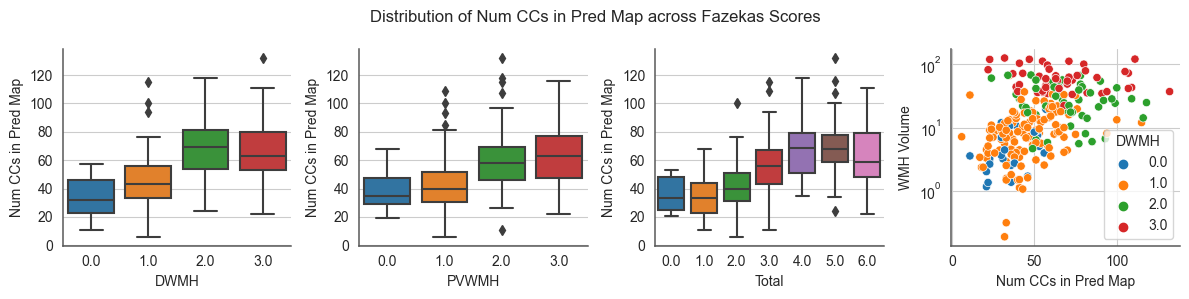

In [456]:
quad_fazekas_comparison_plot_box(combined_df, y='pred0.5_cc_num', ylabel='Num CCs in Pred Map', kind='box')

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


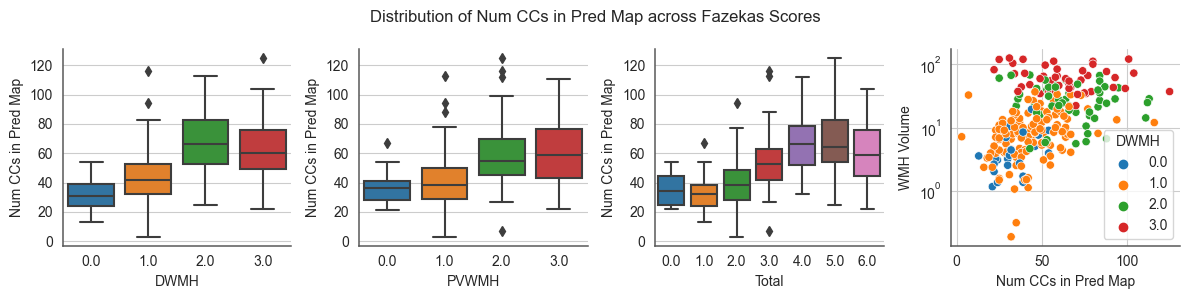

In [461]:
quad_fazekas_comparison_plot_box(combined_df, y='pred0.6_cc_num', ylabel='Num CCs in Pred Map', kind='box')

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


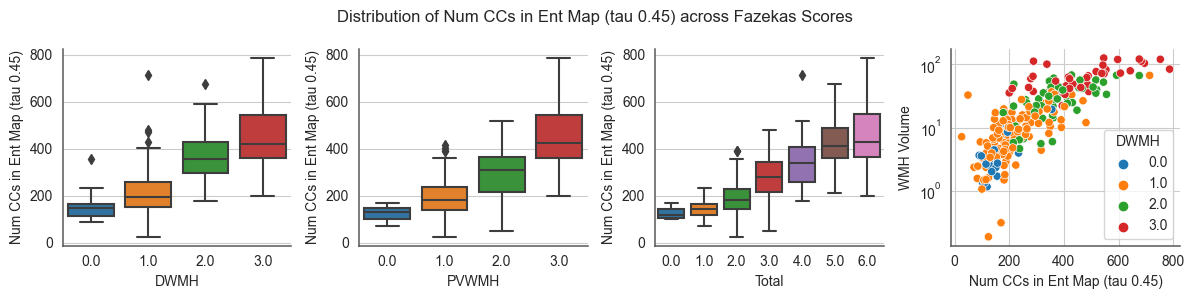

In [457]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.45_cc_num', ylabel='Num CCs in Ent Map (tau 0.45)', kind='box')

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


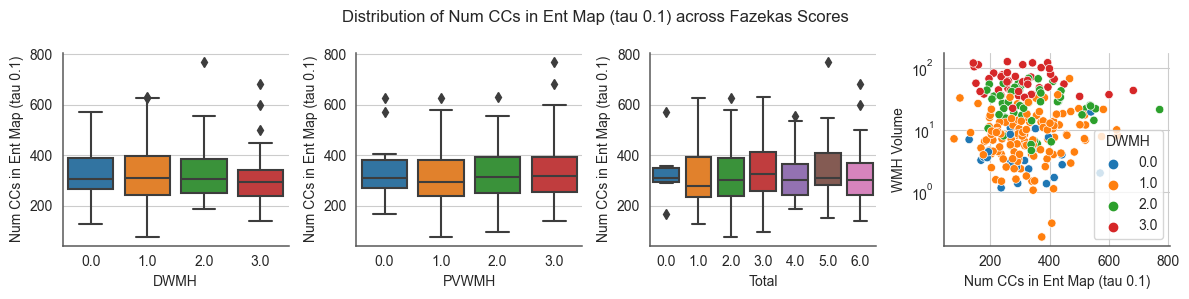

In [458]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.1_cc_num', ylabel='Num CCs in Ent Map (tau 0.1)', kind='box')

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


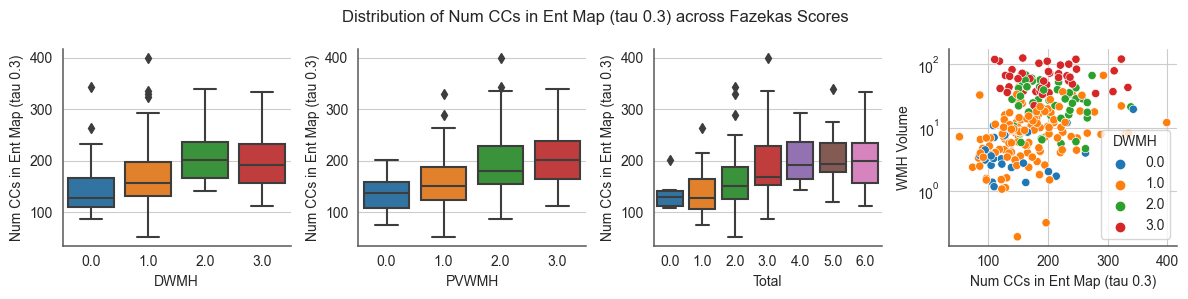

In [459]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.3_cc_num', ylabel='Num CCs in Ent Map (tau 0.3)', kind='box')

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


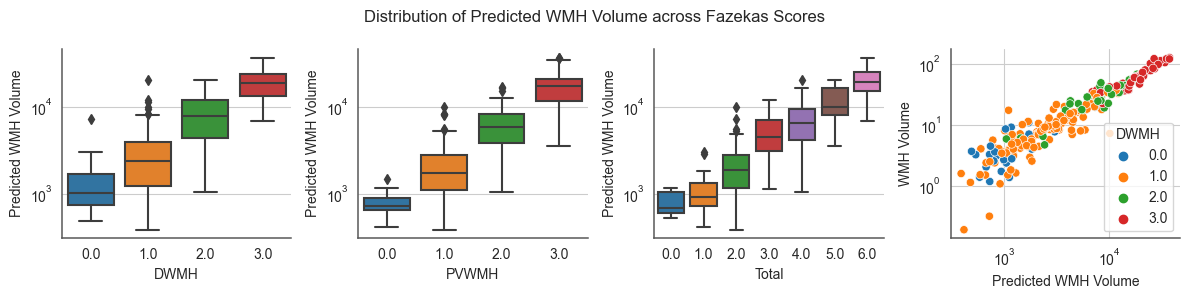

In [460]:
quad_fazekas_comparison_plot_box(combined_df, y='pred0.5_seg_volume', ylabel='Predicted WMH Volume', kind='box', logy=True)

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


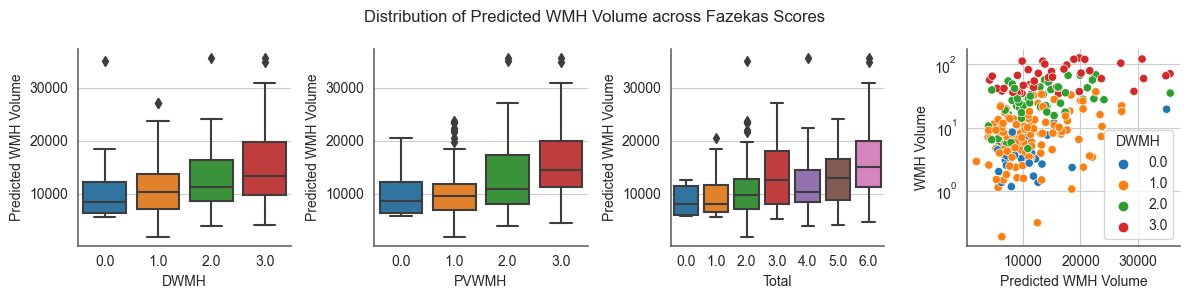

In [576]:
quad_fazekas_comparison_plot_box(combined_df, y='pred0.5_vent_volume', ylabel='Predicted WMH Volume', kind='box', logy=False)

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


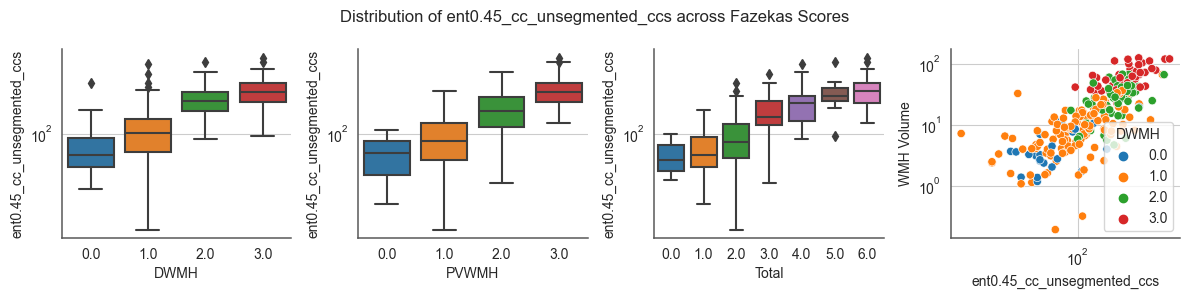

In [438]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.45_cc_unsegmented_ccs', ylabel=None, kind='box', logy=True)

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


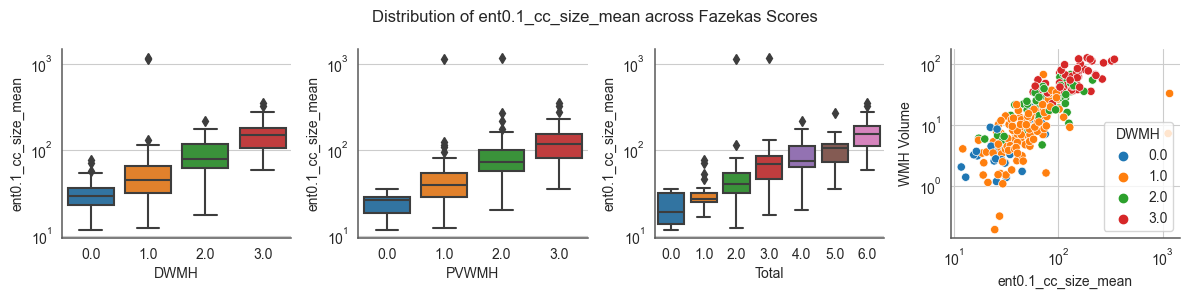

In [441]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.1_cc_size_mean', ylabel=None, kind='box', logy=True)

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


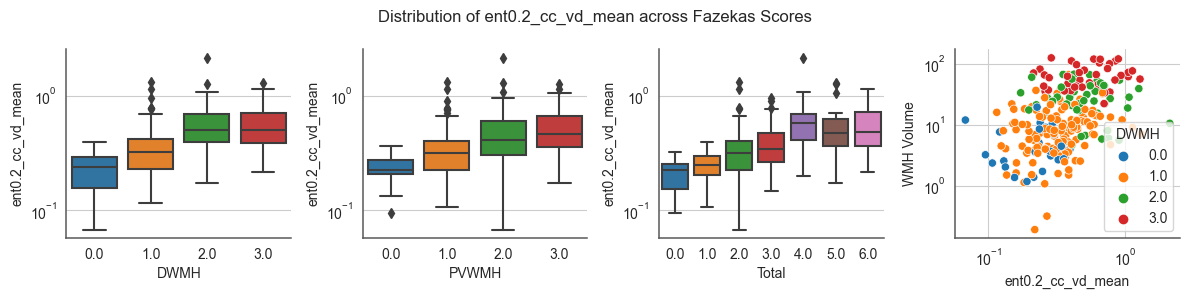

In [573]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.2_cc_vd_mean', ylabel=None, kind='box', logy=True)

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


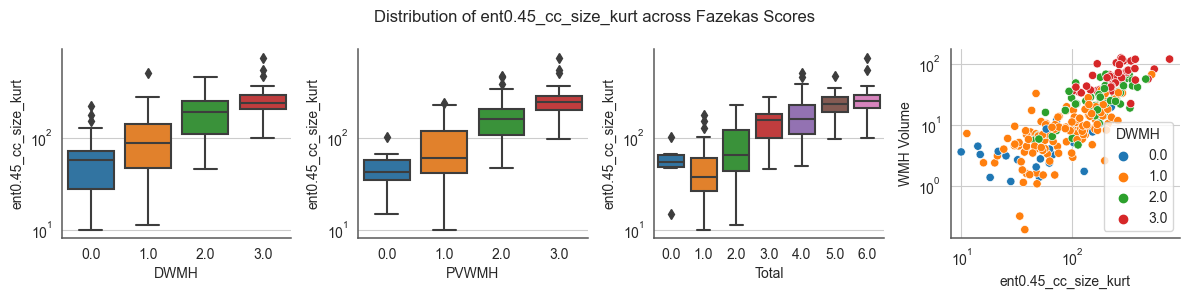

In [571]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.45_cc_size_kurt', ylabel=None, kind='box', logy=True)

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


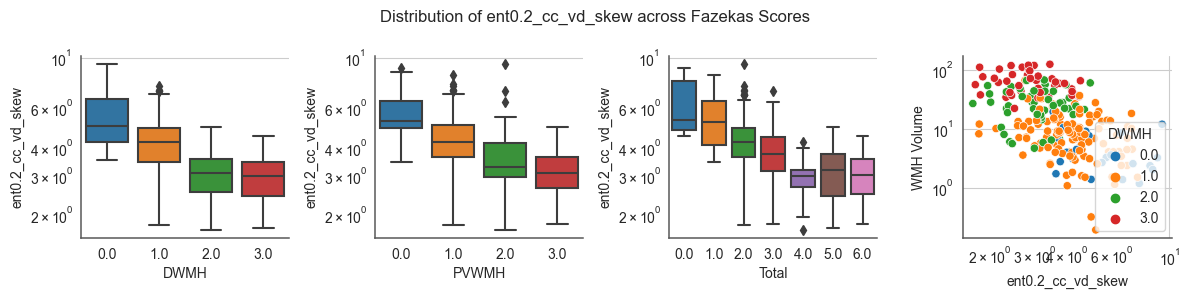

In [569]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.2_cc_vd_skew', ylabel=None, kind='box', logy=True)

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


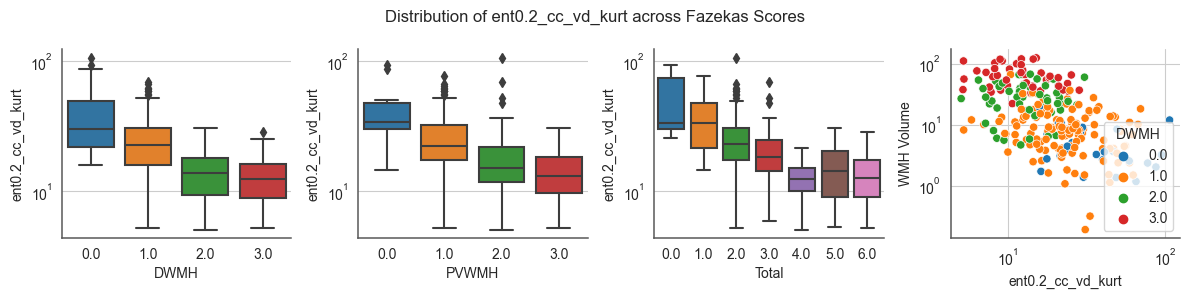

In [567]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.2_cc_vd_kurt', ylabel=None, kind='box', logy=True)

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


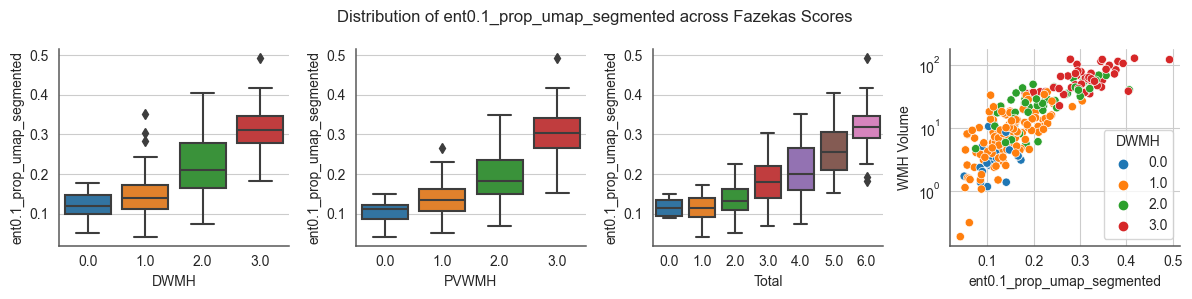

In [565]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.1_prop_umap_segmented', ylabel=None, kind='box', logy=False)

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


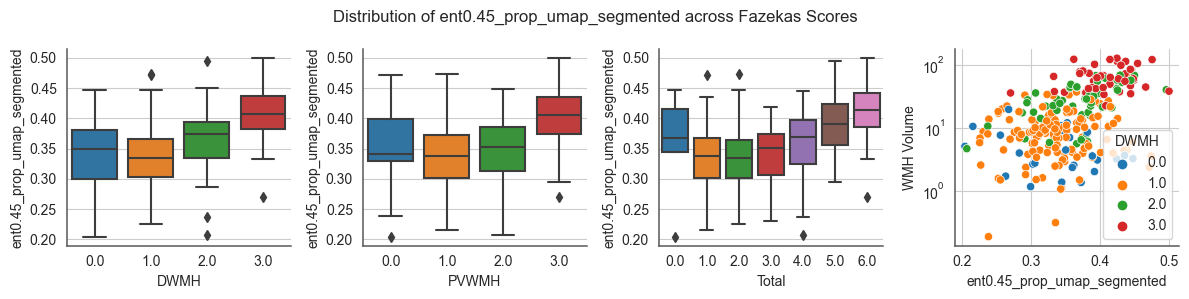

In [564]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.45_prop_umap_segmented', ylabel=None, kind='box', logy=False)

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


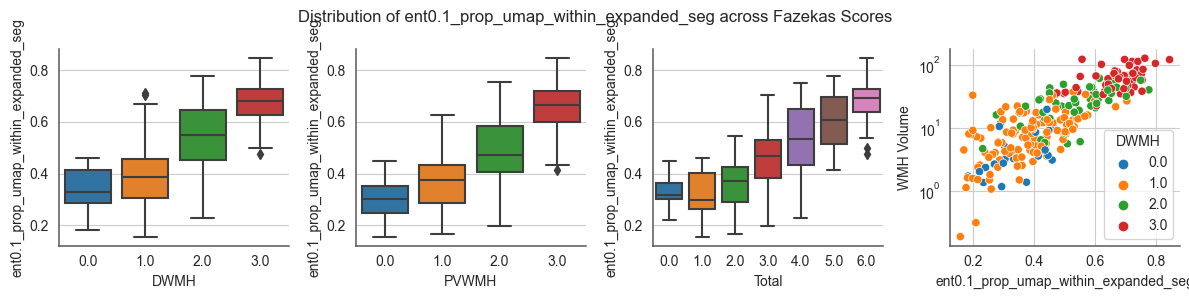

In [561]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.1_prop_umap_within_expanded_seg', ylabel=None, kind='box', logy=False)

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


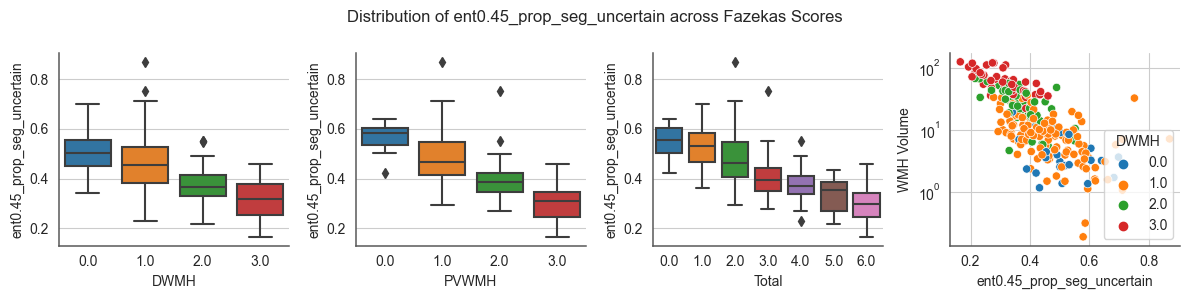

In [558]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.45_prop_seg_uncertain', ylabel=None, kind='box', logy=False)

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


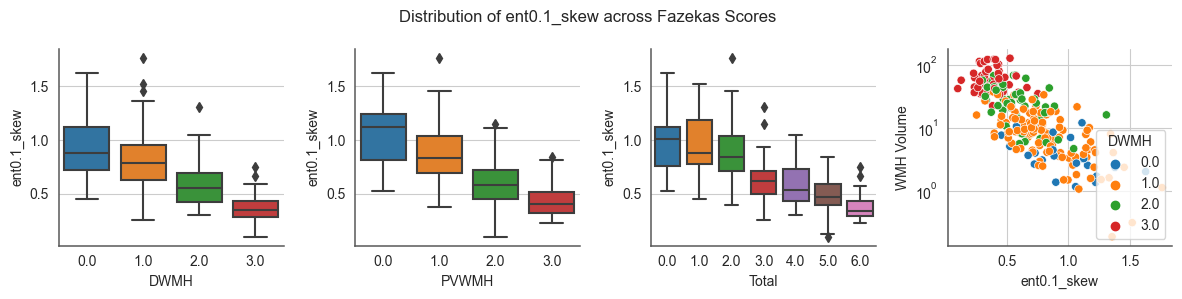

In [557]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.1_skew', ylabel=None, kind='box', logy=False)

/tmp/ipykernel_735809/1825947614.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=sns.color_palette())


[0. 1. 2. 3.]


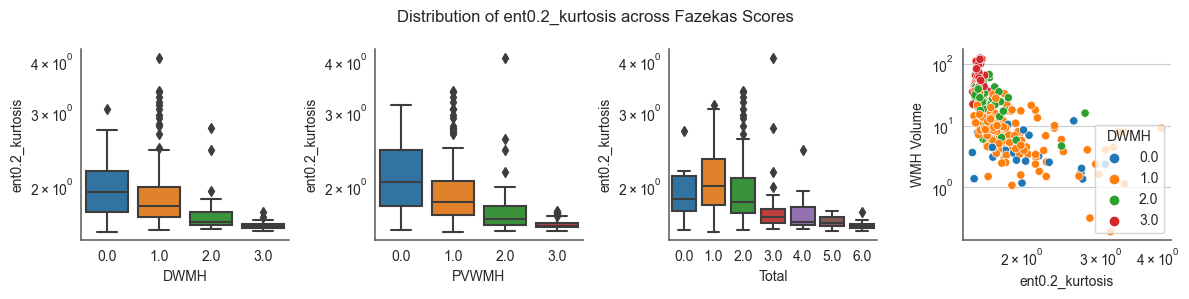

In [556]:
quad_fazekas_comparison_plot_box(combined_df, y='ent0.2_kurtosis', ylabel=None, kind='box')

In [ ]:
# i really need to pick the parameters of each method via tuning, else this is going to take forever. I should see which parameters are most useful to the model
# via cross validation on the validation set, and do the same for pred, seg, etc.

### mean values hist and vd distribution hist
There are a lot of parameters, and I can't see a discernable difference, so I am going to allow the option to include them or not in the grid search...

In [546]:
tau = 0.45
inp_type = "ent"
fazekas_type = "DWMH"
valuehist_keys = [f"{inp_type}{tau}_values_hist_{i}" for i in range(20)]

classes = get_uniques(combined_df, fazekas_type)

In [553]:
df = combined_df
# for c in classes:
c = 3
bar_means = []
sel_df = df.loc[df[fazekas_type] == c]
for vhkey in valuehist_keys:
    bar_means.append(sel_df[vhkey].mean())
    # break

<BarContainer object of 20 artists>

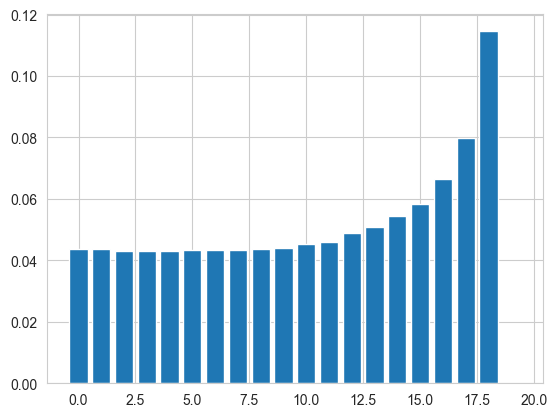

In [554]:
plt.bar(np.arange(0, 20, 1), bar_means)

In [512]:
valuehist_df = combined_df[valuehist_keys]

In [519]:
valuehist_df["ent0.1_values_hist_0"].mean()

0.15522941421236722

In [1]:
'ent0.3_values_hist_0', 'ent0.3_values_hist_1',
'ent0.3_values_hist_2', 'ent0.3_values_hist_3',
'ent0.3_values_hist_4', 'ent0.3_values_hist_5',
'ent0.3_values_hist_6', 'ent0.3_values_hist_7',
'ent0.3_values_hist_8', 'ent0.3_values_hist_9',
'ent0.3_values_hist_10', 'ent0.3_values_hist_11',
'ent0.3_values_hist_12', 'ent0.3_values_hist_13',
'ent0.3_values_hist_14', 'ent0.3_values_hist_15',
'ent0.3_values_hist_16', 'ent0.3_values_hist_17',
'ent0.3_values_hist_18', 'ent0.3_values_hist_19'

('ent0.3_values_hist_18', 'ent0.3_values_hist_19')

In [2]:
combined_df.keys().values

NameError: name 'combined_df' is not defined